# Flowtron inference on COLAB

by Hyungon Ryu | Sr. Data Scientist and center lead @ NVAITC Korea  

- blog https://news.developer.nvidia.com/flowtron-speech-synthesis-model/
- demo samples https://nv-adlr.github.io/Flowtron 
- official github https://arxiv.org/abs/2005.05957
- 



# setup for Flowtron




###  check  GPU is enabled on Colab

In [1]:
%%bash
nvidia-smi

Tue May 19 02:54:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### clone the repo and install python requirements on colab
It will takes about 40 seconds to clone and install whole required python modules. Ignore some errors. 

In [0]:
%%time 
%%bash
git clone https://github.com/NVIDIA/flowtron.git
cd /content/flowtron  
git submodule init
git submodule update

cd /content/flowtron/tacotron2
git submodule init
git submodule update

cd /content/flowtron
pip install  -r requirements.txt 

## download model chechcpoints
It will takes about 15 seconds to download all files.
 - flowtron checkpoint for single voice ljspeech from google drive
 - flowtron checkpoint for multiple voices Libritts from google drive
 - waveglow checkpoint for ljspeech from NVIDIA NGC model repo

In [3]:
%%time
%%bash
wget -N  -q https://raw.githubusercontent.com/yhgon/colab_utils/master/gfile.py
python gfile.py -u 'https://drive.google.com/open?id=1Cjd6dK_eFz6DE0PKXKgKxrzTUqzzUDW-' -f 'flowtron_ljs.pt'
python gfile.py -u 'https://drive.google.com/open?id=1KhJcPawFgmfvwV7tQAOeC253rYstLrs8' -f 'flowtron_libritts.pt'
wget -N  -q  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/3/files/waveglow_256channels_ljs_v3.pt
ls -alh  *.pt

It took  2.62sec to download 232.6 MB flowtron_ljs.pt 
It took  2.19sec to download 232.7 MB flowtron_libritts.pt 
-rw-r--r-- 1 root root 233M May 19 02:57 flowtron_libritts.pt
-rw-r--r-- 1 root root 233M May 19 02:57 flowtron_ljs.pt
-rw-r--r-- 1 root root 645M Oct 28  2019 waveglow_256channels_ljs_v3.pt
CPU times: user 4.78 ms, sys: 3.02 ms, total: 7.81 ms
Wall time: 15.9 s


## modify script to measure inference speed 
I just add some script to measure the inference speed.
you could omit this step if you don't need to measure the perf.  

In [4]:
#@title add tic/toc on inference.py
%%file /content/flowtron/inference.py

###############################################################################
#
#  Copyright (c) 2020, NVIDIA CORPORATION. All rights reserved.
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
###############################################################################
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt

import os
import argparse
import json
import sys
import numpy as np
import torch

import time 

from flowtron import Flowtron
from torch.utils.data import DataLoader
from data import Data
from train import update_params

sys.path.insert(0, "tacotron2")
sys.path.insert(0, "tacotron2/waveglow")
from glow import WaveGlow
from scipy.io.wavfile import write



def infer(flowtron_path, waveglow_path, text, speaker_id, n_frames, sigma,
          seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # load waveglow
    waveglow = torch.load(waveglow_path)['model'].cuda().eval()
    waveglow.cuda().half()
    for k in waveglow.convinv:
        k.float()
    waveglow.eval()

    # load flowtron
    model = Flowtron(**model_config).cuda()
    state_dict = torch.load(flowtron_path, map_location='cpu')['state_dict']
    model.load_state_dict(state_dict)
    model.eval()
    print("Loaded checkpoint '{}')" .format(flowtron_path))

    ignore_keys = ['training_files', 'validation_files']
    trainset = Data(
        data_config['training_files'],
        **dict((k, v) for k, v in data_config.items() if k not in ignore_keys))

    tic_prep = time.time()

    str_text = text 
    num_char = len(str_text)
    num_word = len(str_text.split() )

    speaker_vecs = trainset.get_speaker_id(speaker_id).cuda()
    text = trainset.get_text(text).cuda()

    speaker_vecs = speaker_vecs[None]
    text = text[None]
    toc_prep = time.time()


    tic_flowtron = time.time()
    with torch.no_grad():
        tic_residual = time.time()
        residual = torch.cuda.FloatTensor(1, 80, n_frames).normal_() * sigma
        toc_residual = time.time()        
        mels, attentions = model.infer(residual, speaker_vecs, text)
        toc_flowtron = time.time()    

    for k in range(len(attentions)):
        attention = torch.cat(attentions[k]).cpu().numpy()
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].imshow(mels[0].cpu().numpy(), origin='bottom', aspect='auto')
        axes[1].imshow(attention[:, 0].transpose(), origin='bottom', aspect='auto')
        fig.savefig('sid{}_sigma{}_attnlayer{}.png'.format(speaker_id, sigma, k))
        plt.close("all")

    tic_waveglow = time.time()
    audio = waveglow.infer(mels.half(), sigma=0.8).float()
    toc_waveglow = time.time()


    audio = audio.cpu().numpy()[0]
    # normalize audio for now
    audio = audio / np.abs(audio).max()

    len_audio = len(audio)
    dur_audio = len_audio / 22050
    num_frames = int(len_audio / 256)
    
    dur_prep = toc_prep - tic_prep
    dur_residual = toc_residual - tic_residual
    dur_flowtron_in = toc_flowtron - toc_residual
    dur_flowtron_out = toc_flowtron - tic_residual
    dur_waveglow = toc_waveglow - tic_waveglow        
    dur_total = dur_prep + dur_flowtron_out + dur_waveglow 

    RTF =  dur_audio / dur_total

    str_text =  "\n text : " + str_text
    str_num   = "\n text {:d} char {:d} words  ".format(num_char, num_word ) 
    str_audio = "\n generated audio : {:2.3f} samples  {:2.3f} sec  with  {:d} mel frames ".format( len_audio, dur_audio, num_frames ) 
    str_perf  = "\n total time {:2.3f} = text prep {:2.3f} + flowtron{:2.3f} + wg {:2.3f}  ".format( dur_total, dur_prep, dur_flowtron_out, dur_waveglow ) 
    str_flow   ="\n total flowtron {:2.3f} = residual cal {:2.3f} + flowtron {:2.3f}  " .format(dur_flowtron_out, dur_residual, dur_flowtron_in  ) 
    str_rtf   = "\n RTF is {:2.3f} x   ".format(RTF ) 

    print(str_text,  str_num, str_audio, str_perf, str_flow, str_rtf  )  


    write("sid{}_sigma{}.wav".format(speaker_id, sigma),
          data_config['sampling_rate'], audio)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-c', '--config', type=str,
                        help='JSON file for configuration')
    parser.add_argument('-p', '--params', nargs='+', default=[])
    parser.add_argument('-f', '--flowtron_path',
                        help='Path to flowtron state dict', type=str)
    parser.add_argument('-w', '--waveglow_path',
                        help='Path to waveglow state dict', type=str)
    parser.add_argument('-t', '--text', help='Text to synthesize', type=str)
    parser.add_argument('-i', '--id', help='Speaker id', type=int)
    parser.add_argument('-n', '--n_frames', help='Number of frames',
                        default=400, type=int)
    parser.add_argument('-o', "--output_dir", default="results/")
    parser.add_argument("-s", "--sigma", default=0.5, type=float)
    parser.add_argument("--seed", default=1234, type=int)
    args = parser.parse_args()

    # Parse configs.  Globals nicer in this case
    with open(args.config) as f:
        data = f.read()

    global config
    config = json.loads(data)
    update_params(config, args.params)

    data_config = config["data_config"]
    global model_config
    model_config = config["model_config"]

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    infer(args.flowtron_path, args.waveglow_path, args.text, args.id,
          args.n_frames, args.sigma, args.seed)



Overwriting /content/flowtron/inference.py


## plot utility 
to check more detail magnitude spectrogram from synthesized wav

In [0]:
#@title plot utility

import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline

import wave
import librosa
import numpy as np
def load_wav(filepath, sr=22050, mono=True, dur=None):
    wav, orig_sr = librosa.core.load(filepath, sr=sr, mono=mono)
    if (dur == None):
        wav_final   = wav
    else:
        wav_final   = wav[0: int(dur*sr) ]
    n_samples = len(wav_final)
    dur =  np.round(  n_samples / sr , 2) 
    return wav_final, sr, n_samples, dur


def plot_mag(filepath, n_fft=1024, hop_ratio=4, win='hanning', sr=22050):

    wav, sr, _, _ = load_wav(filepath)

    win_length = n_fft
    hop_ratio = 4
    hop_length = int(n_fft/hop_ratio)
    target_bins = int ( n_fft /2 +1 )

    num_samples  = int( len(wav) ) 
    spectrogram = librosa.stft(wav[:num_samples], n_fft=n_fft,  win_length=win_length, hop_length=hop_length, window='hann' )
    magnitude = np.abs(spectrogram)
    magnitude_db = 10*np.log10(magnitude**2)

    print( n_fft, win_length , hop_length , target_bins, magnitude_db.shape )

    plt.figure(figsize=(14, 1))
    plt.ylim( -1, 1)
    plt.plot(wav)
    plt.figure(figsize=(16, int(4)))
    plt.yscale('linear')
    a=plt.imshow(magnitude_db, norm=None, cmap='magma', origin='lower' , interpolation=None, aspect='auto' )
    plt.colorbar( a)

=============================================

# Synthesize Single Speaker Voice 
(female voice LJSpeech)

## configure


Type any sentence which you want to synthesize

In [0]:
#input_text ='well know that deep generative models have a deep latent space!'
input_text = 'The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read.'

In [0]:
sigma =  0.8          # modify 0.5 ~ 1.0
n_frames =  1200      # max frames ( 88 frames per 1 sec in SR 22khz sampling )

In [35]:
import os
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

gen_filename = 'sid' + str(0) + '_sigma'+ str(sigma)
gen_wav_fname = os.path.join('/content/flowtron', gen_filename+'.wav' )
gen_plot0_fname = os.path.join('/content/flowtron', gen_filename+'_attnlayer0.png' )
gen_plot1_fname = os.path.join('/content/flowtron', gen_filename+'_attnlayer0.png' )
print(gen_wav_fname, ": ",pick_speaker_id, sigma, input_text, n_frames)

def colab_v(val): # utility pass the python variable to colab shell
    return '\''+ str(val) +  '\''

sigma           = colab_v(sigma)
n_frames        = colab_v(n_frames)  
input_text      = colab_v(input_text)   

/content/flowtron/sid0_sigma0.8.wav :  '7511' 0.8 The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read. 1200


## run the inference script

/content/flowtron
0.8 1200 The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read.
synthesized wav file is
$/content/flowtron/sid0_sigma0.8.wav
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/pytho

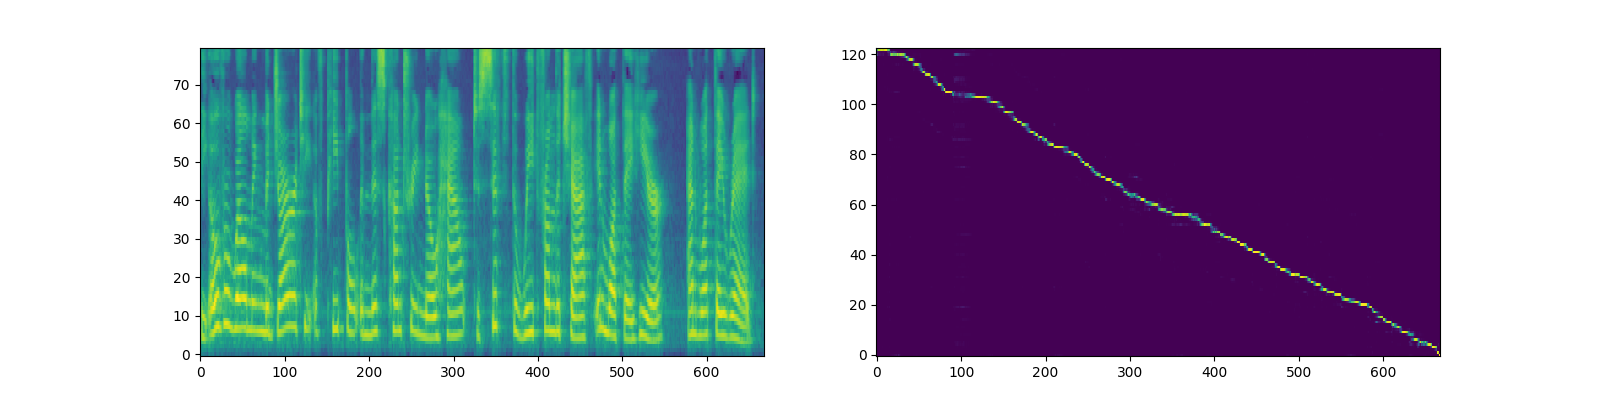

In [36]:
%cd /content/flowtron
!echo  ${sigma} ${n_frames}   ${input_text}  
!echo "synthesized wav file is" && echo ${gen_wav_fname}
!python inference.py -c config.json -f /content/flowtron_ljs.pt -w /content/waveglow_256channels_ljs_v3.pt -t ${input_text} -i 0 -n ${n_frames} -s ${sigma}
from IPython.display import display, Audio, Image
display(Audio(gen_wav_fname ))
display(Image(filename=gen_plot0_fname))
#plot_mag(gen_wav_fname)

===============================================




# Synthesize multiple Voices 
( 123 LibriTTS voices, 64 females, 59 males)


## configure json file 
for libritts dataset, you need additional config file to fit in libritts dataset specially sid `config_libritts.json`

In [16]:
#@title configure libritts config_libritts.json 
%%file /content/flowtron/config_libritts.json
{
    "train_config": {
        "output_directory": "outdir",
        "epochs": 10000000,
        "learning_rate": 1e-4,
        "weight_decay": 1e-6,
        "sigma": 1.0,
        "iters_per_checkpoint": 5000,
        "batch_size": 1,
        "seed": 1234,
        "checkpoint_path": "",
	    "ignore_layers": [],
        "include_layers": ["speaker", "encoder", "embedding"],
        "warmstart_checkpoint_path": "",
	    "with_tensorboard": true,
        "fp16_run": false
    },
    "data_config": {
        "training_files": "filelists/libritts_train_clean_100_audiopath_text_sid_shorterthan10s_atleast5min_train_filelist.txt", 
        "validation_files": "filelists/libritts_train_clean_100_audiopath_text_sid_atleast5min_val_filelist.txt",
        "text_cleaners": ["flowtron_cleaners"],
        "p_arpabet": 0.5,
        "cmudict_path": "data/cmudict_dictionary",
        "sampling_rate": 22050,
        "filter_length": 1024,
        "hop_length": 256,
        "win_length": 1024,
        "mel_fmin": 0.0,
        "mel_fmax": 8000.0,
        "max_wav_value": 32768.0
    },
    "dist_config": {
        "dist_backend": "nccl",
        "dist_url": "tcp://localhost:54321"
    },
    
    "model_config": {
        "n_speakers": 123,
        "n_speaker_dim": 128,
        "n_text": 185,
        "n_text_dim": 512,
        "n_flows": 2,
        "n_mel_channels": 80,
        "n_attn_channels": 640,
        "n_hidden": 1024,
        "n_lstm_layers": 2,
        "mel_encoder_n_hidden": 512,
        "n_components": 0,
        "mean_scale": 0.0,
        "fixed_gaussian": true,
        "dummy_speaker_embedding": false,
        "use_gate_layer": true
    } 
}

Writing /content/flowtron/config_libritts.json


## extract speakr id from libritts and flowtron
librispeech have many speakers but flowtron select voices which is long enough more  20 minutes. 

In [17]:
import os
import sys

import pandas as pd 
import numpy as np 
import random
from itertools import cycle
from data import  load_filepaths_and_text

!cat /content/flowtron/filelists/libritts_speakerinfo.txt | tail -n +12  | head -n 10

filelist_path = "/content/flowtron/filelists/libritts_train_clean_100_audiopath_text_sid_shorterthan10s_atleast5min_train_filelist.txt"

def create_speaker_lookup_table(audiopaths_and_text):
    speaker_ids = np.sort(np.unique([x[2] for x in audiopaths_and_text]))
    d = {int(speaker_ids[i]): i for i in range(len(speaker_ids))}
    print("Number of speakers :", len(d))
    return d

audiopaths_and_text = load_filepaths_and_text(filelist_path)
speaker_ids  = create_speaker_lookup_table(audiopaths_and_text).keys() 
print(speaker_ids)
speakers = pd.read_csv('/content/flowtron/filelists/libritts_speakerinfo.txt', engine='python',header=None, comment=';', sep=' *\| *',  names=['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME'])
speakers['FLOWTRON_ID'] = speakers['ID'].apply(lambda x: x if x in speaker_ids else -1)

female_speakers =   speakers.query("SEX == 'F' and MINUTES > 20 and FLOWTRON_ID >= 0")['FLOWTRON_ID'].sample(frac=1).tolist() 
male_speakers   =   speakers.query("SEX == 'M' and MINUTES > 20 and FLOWTRON_ID >= 0")['FLOWTRON_ID'].sample(frac=1).tolist() 

print("females speakers : ", len(female_speakers), female_speakers )
print("male speakers    : ", len(male_speakers), male_speakers )



;ID  |SEX| SUBSET           |MINUTES| NAME
14   | F | train-clean-360  | 25.03 | Kristin LeMoine
16   | F | train-clean-360  | 25.11 | Alys AtteWater
17   | M | train-clean-360  | 25.04 | Gord Mackenzie
19   | F | train-clean-100  | 25.19 | Kara Shallenberg
20   | F | train-other-500  | 30.07 | Gesine
22   | F | train-clean-360  | 25.14 | Michelle Crandall
23   | F | train-clean-360  | 25.23 | Anita Roy Dobbs
25   | M | train-other-500  | 30.16 | John Gonzalez
26   | M | train-clean-100  | 25.08 | Denny Sayers
Number of speakers : 123
dict_keys([1069, 1088, 1116, 118, 1246, 125, 1263, 1502, 1578, 1841, 1867, 196, 1963, 1970, 200, 2092, 2136, 2182, 2196, 2289, 2416, 2436, 250, 254, 2836, 2843, 2911, 2952, 3240, 3242, 3259, 3436, 3486, 3526, 3664, 374, 3857, 3879, 3982, 3983, 40, 4018, 405, 4051, 4088, 4160, 4195, 4267, 4297, 4362, 4397, 4406, 446, 460, 4640, 4680, 4788, 5022, 5104, 5322, 5339, 5393, 5652, 5678, 5703, 5750, 5808, 587, 6019, 6064, 6078, 6081, 6147, 6181, 6209, 6272, 6367,

## select random voice

In [37]:
gender = 'Female'  # select gender 'F', 'Male' or None

random_speaker_all    =  str(random.choice(list(speaker_ids)))
random_speaker_female =  str(random.choice(female_speakers))
random_speaker_male =  str(random.choice(male_speakers))

if gender == None : 
    pick_speaker_id = random_speaker_all
if gender == 'Female':
    pick_speaker_id = random_speaker_female
elif gender == 'Male' :
    pick_speaker_id = random_speaker_male

print(gender, pick_speaker_id)

Female 3526


## type sentence which you want to synthesize.

In [0]:
#input_text ='well know that deep generative models have a deep latent space!'
input_text = 'The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read.'
sigma =  0.8
n_frames =  1200


pass to colab shell

In [39]:
gen_filename = 'sid' + str(pick_speaker_id) + '_sigma'+ str(sigma)
gen_wav_fname = os.path.join('/content/flowtron', gen_filename+'.wav' )
gen_plot0_fname = os.path.join('/content/flowtron', gen_filename+'_attnlayer0.png' )
gen_plot1_fname = os.path.join('/content/flowtron', gen_filename+'_attnlayer0.png' )
print(gen_wav_fname, ":", gender  ,pick_speaker_id, sigma, input_text, n_frames)

def colab_v(val):
    return '\''+ str(val) +  '\''

sigma           = colab_v(sigma)
n_frames        =  colab_v(n_frames)  
pick_speaker_id = colab_v(pick_speaker_id)
input_text      = colab_v(input_text)   
gender          = colab_v(gender)   


/content/flowtron/sid3526_sigma0.8.wav : Female 3526 0.8 The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read. 1200


## synthesize the sentence with random voice

/content/flowtron
Female 3526 0.8 The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read. 1200
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: So

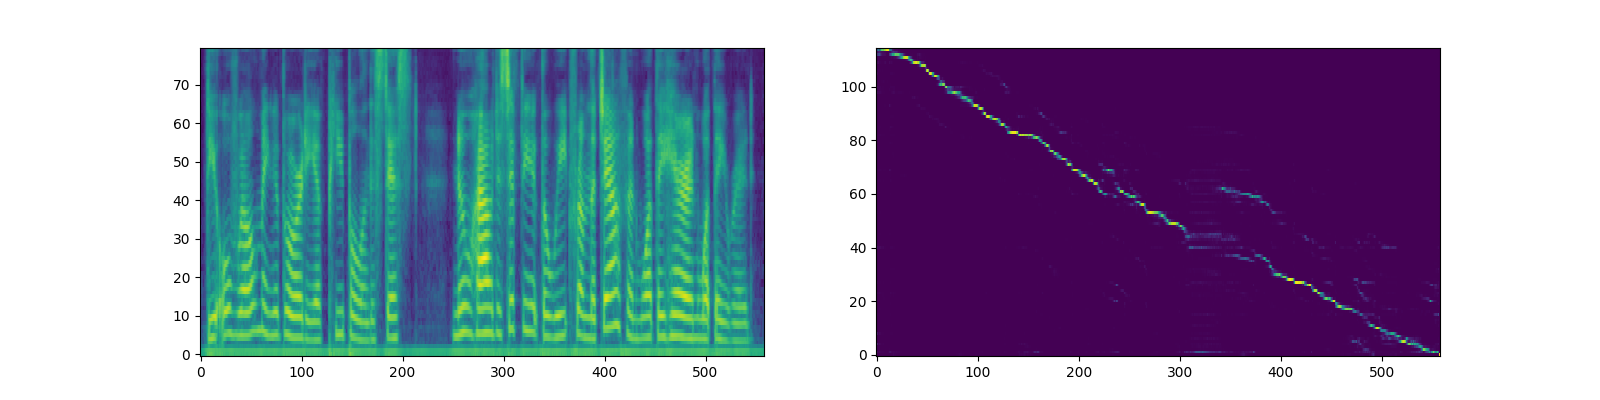

In [40]:
%cd /content/flowtron
!echo ${gender} ${pick_speaker_id}    ${sigma} ${input_text}  ${n_frames} 
!python inference.py -c config_libritts.json -f /content/flowtron_libritts.pt -w /content/waveglow_256channels_ljs_v3.pt -t ${input_text} -i ${pick_speaker_id} -n ${n_frames} -s ${sigma}
from IPython.display import display, Audio, Image
display(Audio(gen_wav_fname ))
display(Image(filename=gen_plot0_fname))
#plot_mag(gen_wav_fname)

### end of jupyter